In [236]:
from shapely.ops import nearest_points
from shapely.geometry import Point, Polygon, LineString
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [237]:
def is_point_a_vertex(coords, point, distance_threshold=1e-6):
    # all are numpy arrays
    distances_to_vertices = np.linalg.norm(coords - point, axis=1)
    
    # Check if the point is exactly one of the vertices
    if np.any(np.isclose(distances_to_vertices, 0, atol=distance_threshold)):
        return np.argmin(distances_to_vertices)



def find_vertex_after_point_opt(coords, point: tuple) -> int | None:
    point_np = np.array(point)
    vertex = is_point_a_vertex(coords,point_np)
    if vertex is not None:
      return vertex

    # Define a small distance threshold for approximation
    distance_threshold = 1e-6

    # Prepare arrays for vectorized edge distance calculation
    start_points = coords[:-1]
    end_points = coords[1:]
    edge_vectors = end_points - start_points
    point_vectors = point_np - start_points

    # Compute cross product and dot product for distance calculation
    cross_prod = np.cross(edge_vectors, point_vectors)
    dot_prod = np.einsum('ij,ij->i', edge_vectors, point_vectors)
    edge_lengths = np.linalg.norm(edge_vectors, axis=1)

    # Calculate distance from point to each edge
    distances = np.abs(cross_prod) / edge_lengths
    within_edges = (dot_prod > 0) & (dot_prod < np.einsum('ij,ij->i', edge_vectors, edge_vectors))

    # Check if the point is close to any edge
    close_edges = np.where((distances < distance_threshold) & within_edges)[0]
    if close_edges.size > 0:
        return (close_edges[0] + 1) % (coords.shape[0]-1)

    return None


In [238]:
def move_point_along_perimeter(polygon:Polygon, point:tuple, length:float|int):
    perimeter_length = polygon.length
    #if the length is longer than the perimeter, make it the remainder 
    length = length % perimeter_length 
    perimeter = polygon.exterior

    coords = np.array(perimeter.coords)
    current_distance = 0

    # Find the index of the vertex after the current point
    vertex_idx = find_vertex_after_point_opt(coords, point)
    current_point = np.array(point)
    
    # Rearrange coordinates so the loop starts from the vertex after the current point
    # print(f"{coords=}, {vertex_idx=}")
    # coords = coords[vertex_idx:-1] + coords[:vertex_idx+1]
    coords = np.concatenate((coords[vertex_idx:-1], coords[:vertex_idx+1]))
    # print(f"{new_coords=}")
    for i, p in enumerate(coords):
        next_vertex = np.array(p)
        segment_length = np.linalg.norm(next_vertex-current_point)
        # print(f"{current_point=}, {next_vertex=} {segment_length=}")
        if current_distance + segment_length >= length:
            # Interpolate point on the segment
            remaining_length = length - current_distance
            ratio = remaining_length / segment_length
            # vector_to_final_point = next_vertex-current_point
            # print(f"{vector_to_final_point=}, {ratio=}")
            new_point = current_point + ratio * (next_vertex-current_point)
            # new_x = current_point.x + ratio * (next_point.x - current_point.x)
            # new_y = current_point.y + ratio * (next_point.y - current_point.y)
            # print(f"{new_point=}")
            return tuple(new_point)

        current_distance += segment_length
        current_point = next_vertex

    # return initial point if there are any issues 
    # NOTE this might be unreachable if the function was properly designed
    return None

In [239]:

def generate_half_line_positions(L, progression_func, smallest_gap, uniform_range):
    # Create initial uniformly spaced positions
    midpoint = L/2
    uniform_gaps = np.arange(midpoint, midpoint+uniform_range/2, smallest_gap)
    last_uniform_pos = uniform_gaps[-1] if len(uniform_gaps) > 0 else 0

    # Estimate the number of progressive gaps needed
    test_gap = smallest_gap
    test_pos = last_uniform_pos
    num_gaps = 0
    while test_pos < L:
        test_gap = progression_func(test_gap)
        test_pos += test_gap
        num_gaps += 1

    # Generate all progressive gaps using a geometric progression
    progressive_gaps = smallest_gap * np.geomspace(1, progression_func(1)**(num_gaps - 1), num=num_gaps)

    # Compute progressive positions
    progressive_positions = last_uniform_pos + np.cumsum(progressive_gaps)
    progressive_positions = progressive_positions[progressive_positions < L]

    # Combine uniform and progressive positions
    positions = np.concatenate((uniform_gaps, progressive_positions))

    return positions.tolist()

def mirror_positions(positions, L):
    # Mirror the positions across the midpoint
    print(f"{L=}")
    mirrored = [L - pos for pos in reversed(positions)]
    return mirrored[:-1] + positions  # Exclude the midpoint from one side to avoid duplication

Let's start with the point and its opposite on the other side

t=0.00034370901994407177
input_point=(6.0, 2.0)


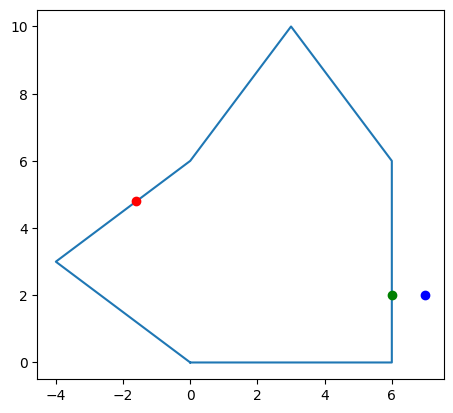

In [240]:
point = Point(7, 2)


h = 6
polygon = Polygon([(0, 0), (6, 0), (6, h),(3,h+4), (0, h), (-4, h/2)])
perimeter = polygon.length
coords = np.array(polygon.exterior.coords)


p1, p2 = nearest_points(polygon, point)
input_point = (p1.x, p1.y)
t= time.perf_counter()
opposite_point = move_point_along_perimeter(polygon, input_point, perimeter/2)
t= time.perf_counter()-t
print(f"{t=}")
plt.plot(*polygon.exterior.xy)
plt.plot(*point.xy, 'bo')
plt.plot(*input_point, 'go')
print(f"{input_point=}")
plt.plot(*opposite_point, 'ro')

#set the aspect ratio to 1 (by getting current axes)

ax = plt.gca()

ax.set_aspect('equal', adjustable='box')

plt.show()

Get edge information

In [241]:
t = time.perf_counter()

differences = np.diff(coords, axis=0)
# print(differences)

# Calculate the Euclidean distances from each vertex to the next
edge_lengths = np.linalg.norm(differences, axis=1)
# print(edge_lengths)
#add a leading zero
# vertex_distances = np.insert(vertex_distances, 0,0)


t = time.perf_counter()-t

print(f"{t=}")

cumul_edge_lengths = np.cumsum(edge_lengths)
print("Edge lengths =", edge_lengths)

t=0.00022233393974602222
Edge lengths = [6. 6. 5. 5. 5. 5.]


Define cascading array class

In [242]:
class CascadingArrays:
    def __init__(self, arrays, max_values):
        self.arrays = arrays
        self.max_values = max_values

    def add(self, value):
        # Increment all arrays first
        for i in range(len(self.arrays)):
            self.arrays[i] += value

        # Then cascade
        for i in range(len(self.arrays)):
            self.cascade(i)

    def cascade(self, index):
        overflow = self.arrays[index] > self.max_values[index]
        while np.any(overflow):
            next_index = (index + 1) % len(self.arrays)
            overflow_values = self.arrays[index][overflow] - self.max_values[index]
            self.arrays[index] = self.arrays[index][~overflow]

            # Insert overflow values at the beginning of the next array
            self.arrays[next_index] = np.insert(self.arrays[next_index], 0, overflow_values)

            index = next_index
            overflow = self.arrays[index] > self.max_values[index]


In [243]:
#create subarrays
import bisect
def find_index(arr, x):
    index = bisect.bisect_left(arr, x)
    return max(0, index - 1) if index else -1

#get 1D distances 
progression_func = lambda gap: gap * 1.1

panels1D = generate_half_line_positions(L=perimeter,progression_func=progression_func, smallest_gap=0.01,uniform_range=0.01)
panels1D = mirror_positions(panels1D, L=perimeter)
# print(panels1D)
# Compute differences
# panels1D_diff = np.diff(panels1D, prepend=0.0)
panels1D = np.array(panels1D)
t = time.perf_counter()
split_points1D = []
start = 0
for i, length in enumerate(cumul_edge_lengths):
  prev_len = 0.0 if i==0 else cumul_edge_lengths[i-1]
  # print(prev_len)
  #fpi, furthest panel index
  fpi = find_index(panels1D, length)
  # print(length,idx)
  split_points1D.append(panels1D[start:fpi+1]-prev_len)
  start = fpi+1

# print(split_points1D)

t = time.perf_counter()-t
print(f"{t=}")

L=32.0
t=0.00015104201156646013


In [244]:
cascading_arrays = CascadingArrays(split_points1D.copy(), edge_lengths)

In [245]:
def compute_rotation_matrices(vertices):
    # Calculate differences between successive vertices
    deltas = np.diff(vertices, axis=0)

    # Compute angles to the horizontal
    angles = np.arctan2(deltas[:, 1], deltas[:, 0])
    # print(f"{angles=}")

    # Compute rotation matrices
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotation_matrices = np.array([[cos_angles, -sin_angles], [sin_angles, cos_angles]])
    # print(rotation_matrices)

    # Transpose to get matrices in correct shape
    # look this up to see how it is done exactly
    rotation_matrices = rotation_matrices.transpose(2, 0, 1)

    return rotation_matrices



# Example vertices
# vertices = np.array([[0, 0], [1, 0], [1, 1], [0, 1],[0, 0]])
vertices = coords
# print(f"{vertices=}")

# Compute rotation matrices
t = time.perf_counter()
rotation_matrices = compute_rotation_matrices(vertices)
# print(rotation_matrices)
# print(f"{split_points2D=}")


In [336]:
#whole loop in one go:
h = 2
h = h%32

t = time.perf_counter()
cascading_arrays.add(h)
split_points2D = [np.column_stack((arr, np.zeros(arr.shape))) for arr in cascading_arrays.arrays]
rotated_arrays = [(mat@arr.T).T for mat, arr in zip(rotation_matrices, split_points2D)]
translated_arrays = [arr + vec for arr, vec in zip(rotated_arrays, coords[:-1])]
t = time.perf_counter()-t

print(f"{t=}")

t=0.0004262910224497318


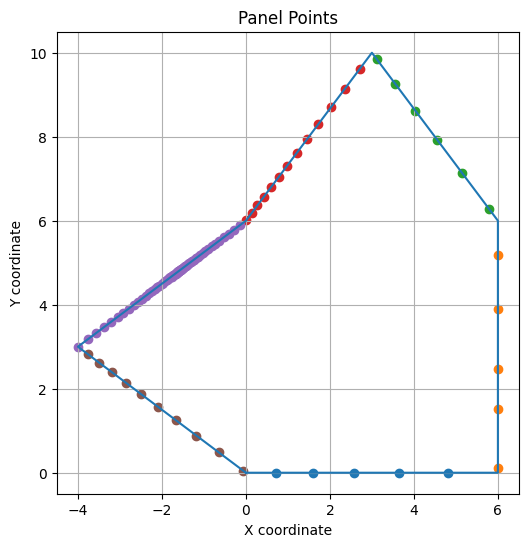

In [337]:
# Plotting the points in the translated_arrays
plt.figure(figsize=(8, 6))

for arr in translated_arrays:
    plt.scatter(arr[:, 0], arr[:, 1])  # Plot each array's points

plt.title('Panel Points')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
ax = plt.gca()

ax.set_aspect('equal', adjustable='box')
plt.plot(*polygon.exterior.xy)

plt.show()